In [55]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [56]:
#cwfis_perims = gpd.read_file("/projects/old_shared/fire_weather_vis/Lightning_analysis/CWFIS/perim_progression/progression.shp")

In [57]:
#cwfis_perims = cwfis_perims.set_crs("EPSG:4326")


In [58]:
#cwfis_perims[1:4].explore()

In [59]:
#cwfis_perims.columns

In [60]:
import seaborn as sn

In [61]:
#cwfis_perims.DATE

In [62]:
# cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
# cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
# #cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
# cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

# heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [63]:
### Sort by lattitude 

# cwfis_perims["x_component"] = cwfis_perims.geometry.centroid.x
# cwfis_perims["y_component"] = cwfis_perims.geometry.centroid.y

# cwfis_perims = cwfis_perims.sort_values(by = "y_component")



# cwfis_perims["log_area"] = np.log(cwfis_perims.AREA)
# cwfis_perims["better_format_date"] = pd.to_datetime(cwfis_perims.DATE.astype("str"), format="%Y%m%d.0")
# #cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
# cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")

# heat = cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]].pivot(index="CONSIS_ID", columns="better_format_date2", values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [64]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]]

In [65]:
#heat.sort_values()

In [66]:
### Now with feds perimeters

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/20_days_fire_stats_only_718270-99999_minT20230301_maxT20230830_BOREAL_NRT_3571_DPSstation20231120.csv" ## looking for lightning 20 days before start

#path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_only/April_1_unmerged_fires_with_FWI.csv" ### The weirder fires. 

path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv" # Fires with "fixed' lf bug. 
fires = fv.prep_fire_files(path)

fires = fires.to_crs(4326)
#fires = fv.remerge_largefire(fires) ### CAUSES ISSUES WITH AREA DIFFERENCING. 

In [67]:
fires.columns

Index(['fireID', 't', 'geometry', 'Unnamed: 0.2', 'csv_geometry',
       'Unnamed: 0.1', 'csv_geometry', 'Unnamed: 0', 'InterCloud', 'lat',
       'lon', 'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry.1',
       'lon_centroid', 'lat_centroid', 'GEOS-5.IMERGEARLY', 'FWI',
       'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5',
       'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire', 'composit_ids',
       'rows_edited'],
      dtype='object')

In [68]:
len(fires.fireID.unique())

134

In [69]:
fires = fires[~fires.geometry.isna()]

In [70]:
fires = fires.sort_values(by = ["fireID", "t"])
fires.farea = fires.farea.astype("int64")
#fires["farea_diff"] = fires.groupby("fireID").farea.diff()

In [71]:
# fires.loc[(fires.farea_diff < 0), ['fireID', 't', 'geometry',  'farea', 'pre_fire', 'composit_ids',
#        'rows_edited', "farea_diff"]]

# fires.loc[(fires.fireID == "10140"), ['fireID', 't', 'geometry',  'farea', 'pre_fire', 'composit_ids',
#        'rows_edited', "farea_diff"]].composit_ids.unique()

In [72]:
#fires[fires.fireID == '12596']

In [73]:
# weird_diff_ids = fires[fires.farea_diff< 0][["fireID", "t", "farea", "farea_diff"]].fireID.unique()

# fires[fires.fireID.isin(weird_diff_ids)][["fireID", "t", "farea", "farea_diff"]]
fires.columns


Index(['fireID', 't', 'geometry', 'Unnamed: 0.2', 'csv_geometry',
       'Unnamed: 0.1', 'csv_geometry', 'Unnamed: 0', 'InterCloud', 'lat',
       'lon', 'current_mag', 'error_elps', 'num_station', 'num_candidates',
       'num_strikes', 'num_strikes_10_days', 'no_strikes_in_time',
       'viirs_pix_count', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 'csv_geometry.1',
       'lon_centroid', 'lat_centroid', 'GEOS-5.IMERGEARLY', 'FWI',
       'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4', 'FWI_lead_5',
       'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire', 'composit_ids',
       'rows_edited'],
      dtype='object')

In [74]:
fires.t.max()

'2023-09-26 00:00:00'

In [75]:
def get_centroid(df):
    df_tmp = df[~df.geometry.isnull()]
    max_t = df_tmp.t.max()
    lat = df_tmp[df_tmp.t == max_t].centroid.y
    lon = df_tmp[df_tmp.t == max_t].centroid.x
    #print(lat.iloc[0])
    df["lat_centroid"] = lat.iloc[0]
    df["lon_centroid"] = lon.iloc[0]
    return(df)

def chop_fires_at_end(df):
    final_t = df[df.n_newpixels > 0].t.max()
    df = df[df.t <= final_t]
    return(df)

In [76]:
#fires = fires.groupby("fireID").apply(get_centroid).reset_index()


fires.t = pd.to_datetime(fires.t, format='ISO8601')

#fires.better_format_date.astype("datetime64[ns]")
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
fires = fires[fires.pretty_date_format.str.contains("PM")] ## Make  only night to night comparisons
fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d")

fires["farea_diff"] = fires.groupby("fireID").farea.diff()

fires = fires.groupby("fireID").apply(chop_fires_at_end).reset_index(drop=True)


fires = fires.groupby("fireID").apply(get_centroid).reset_index(drop=True)

/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

In [77]:
#fires["log_area"] = np.log(fires.farea)


#fires["better_format_date"] = pd.to_datetime(fires.t.astype("str"), format="%Y%m%d.0")
#cwfis_perims.DATE = cwfis_perims.DATE.astype("datetime64[ns]")
#cwfis_perims["better_format_date2"] = cwfis_perims["better_format_date"].astype("datetime64[ns]").dt.strftime("%m-%d")
no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t"]]
#no_dupes[no_dupes.fireID == '9203']

In [78]:
#no_dupes[no_dupes.farea_diff < 0]

In [79]:
# heat = no_dupes.reset_index().pivot_table(index =no_dupes.index ,  columns=["fireID","t"], values="log_area")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [80]:
# no_dupes.t = no_dupes.t.astype('datetime64[ns]')
# no_dupes.fireID = no_dupes.fireID.astype("int64")

no_dupes = no_dupes.dropna()
no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
no_dupes["log_difference"] = np.log(no_dupes.farea_diff)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [81]:
no_dupes.columns

Index(['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference'],
      dtype='object')

In [82]:
# Get the mean centroid point per fireID

lats = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
       'log_difference']].groupby("fireID").lat_centroid.mean().reset_index()
lats

,fireID,lat_centroid
0,10013,52.516399
1,10056,51.141514
2,10140,49.351853
3,10286,54.224434
4,10435,49.048535
...,...,...
124,9188,50.617260
125,9266,50.388105
126,9275,49.756406
127,9791,50.796113


In [83]:
#no_dupes

In [84]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

#no_dupes = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'log_difference', 't']].merge(lats, on = ["fireID"])
no_dupes = no_dupes[['fireID','pretty_date_format', 'farea_diff', 'log_difference', 't']].reset_index().merge(lats, on = ["fireID"])

In [85]:
#no_dupes.farea_diff = no_dupes.farea_diff

In [86]:

no_dupes["farea_diff_mod"] = no_dupes.farea_diff + 1 # Account for log. Minimum = 1. 
no_dupes.loc[(no_dupes.farea_diff_mod < 0), ["farea_diff_mod"]] = 1

print(no_dupes.columns)

#heat = no_dupes.pivot(index =["fireID", "lat_centroid"],  columns=["pretty_date_format"], values="farea_diff")
#heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")
heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff_mod")

Index(['index', 'fireID', 'pretty_date_format', 'farea_diff', 'log_difference',
       't', 'lat_centroid', 'farea_diff_mod'],
      dtype='object')


In [87]:
heat = heat.sort_values(by = "lat_centroid", ascending= False)
heat.index = heat.index.astype("float64")

heat.index = heat.index.values.round(2)



In [88]:
#cwfis_perims[["CONSIS_ID", "log_area", "better_format_date2", "y_component"]][cwfis_perims.CONSIS_ID == 56414]

In [89]:
#no_dupes = no_dupes.set_index(['fireID', 'pretty_date_format', 'farea_diff'], append=True)

In [90]:
# heat = no_dupes[2485:2500].pivot(index = "fireID", columns=["pretty_date_format"], values="farea_diff")
# ax = sn.heatmap(heat, cmap = "YlOrBr")
# ax.set(xlabel="", ylabel="")

In [91]:
#s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/")

In [92]:
#s3.ls("s3://veda-data-store-staging/EIS/other/gridded-FWI/QuebecBigRegions/GEOS-5/GEOS-5.IMERGEARLY/chicletDataNoSmoothing")



In [93]:
# no_dupes[no_dupes.farea_diff <0 ]

In [94]:
FWI_data_south = pd.read_csv("https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecEcoSuppressionRegions/GEOS-5/GEOS-5.IMERGEARLY/90_P/chicletDataNoSmoothing/001.SouthernEcoregions_FullResponseZone.FWI.raw.chiclet.csv")

FWI_data_north = pd.read_csv("https://portal.nccs.nasa.gov/datashare/GlobalFWI/ForecastFWIEXPERIMENTAL/QuebecEcoSuppressionRegions/GEOS-5/GEOS-5.IMERGEARLY/90_P/chicletDataNoSmoothing/002.NorthernEcoregions_LimitedResponseZone.FWI.raw.chiclet.csv")

In [95]:
fwis = FWI_data_south[["INITDATE", "0"]]
fwis = fwis.rename(columns={"0":"GEOS_5"})

fwin = FWI_data_north[["INITDATE", "0"]]
fwin = fwin.rename(columns={"0":"GEOS_5"})

In [96]:
# plt.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
# plt.ylabel("FWI")

In [97]:
# fig, (ax, ax2) = plt.subplots(2)
# ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
# ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
# ax.set_ylabel("FWI")

In [98]:
no_dupes.columns

Index(['index', 'fireID', 'pretty_date_format', 'farea_diff', 'log_difference',
       't', 'lat_centroid', 'farea_diff_mod'],
      dtype='object')

Text(55.847222222222214, 0.5, 'FWI')

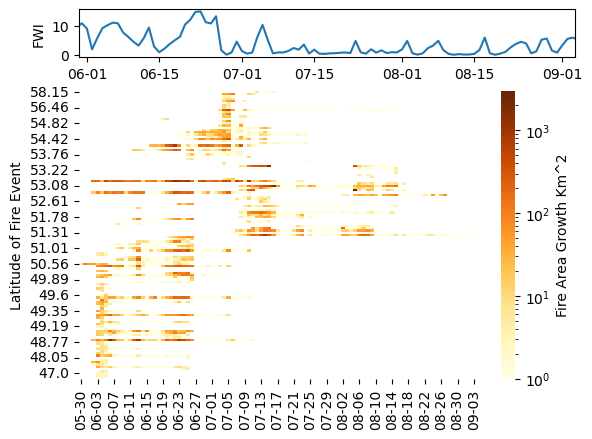

In [99]:
import matplotlib.dates as mdates

fig, (ax, ax2) = plt.subplots(2, gridspec_kw={'height_ratios': [1, 6]})
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
ax.set_ylabel("FWI")
#plt.savefig('Regional_fire_growth_FWI.png')

In [100]:
# dates = heat.columns.values.astype('datetime64[ns]')
# dates.values.astype('datetime64[ns]')

dates = no_dupes['t'].astype('datetime64[ns]')
dates = dates.drop_duplicates()
print(len(dates.dt.strftime('%-m-%-d')))
print(len(heat.columns))

97
97


In [101]:
### New Color bar

from matplotlib.colors import LinearSegmentedColormap

# Retrieve the original colormap
original_cmap = plt.get_cmap('YlOrBr')



def create_darker_colormap(base_cmap_name, darkness_factor):
    """
    Create a darker version of a given colormap.
    
    Parameters:
    - base_cmap_name: str, the name of the base colormap.
    - darkness_factor: float, a factor between 0 and 1 to darken the colormap.
                       1 means no change, 0 means completely dark.
    
    Returns:
    - LinearSegmentedColormap: a new colormap that is a darker version of the base colormap.
    """
    # Retrieve the original colormap
    base_cmap = plt.get_cmap(base_cmap_name)
    
    # Create a list of colors from the colormap and darken them
    colors = base_cmap(np.linspace(0, 1, 256))
    colors[:, :3] *= darkness_factor
    colors = np.clip(colors, 0, 1)  # Ensure values are within [0, 1]
    
    # Create the new colormap
    return LinearSegmentedColormap.from_list(f"{base_cmap_name}_darker", colors)

# Define the darkness factor (between 0 and 1)
darkness_factor = 0.85

# Create a custom colormap with the specified darkness factor
darker_cmap = create_darker_colormap('YlOrBr', darkness_factor)

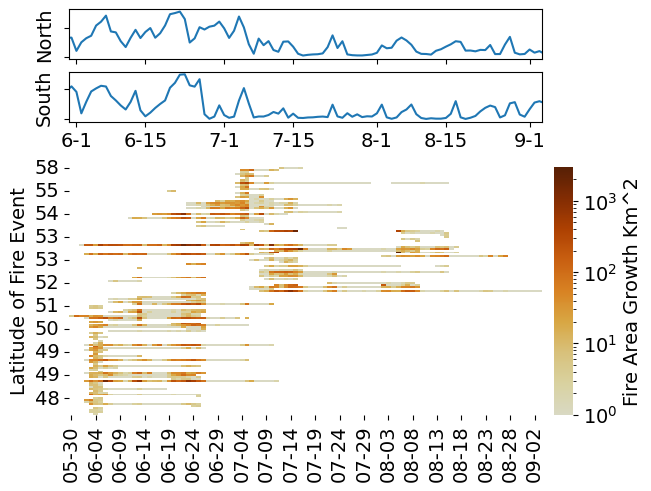

In [165]:
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
#from matplotlib.ticker import IndexFormatter
# fig, ax  = plt.subplots(2, 2, sharex='col', gridspec_kw={'width_ratios':[100,5]})
# ax[0,1].remove()  # remove unused upper right axes
# ax[0,0].plot(x+0.5,L_1,'-', marker='o',color='tab:orange')
# sn.heatmap(M_1, cmap=cmap, vmax=np.max(M_1), center=np.max(M_1)/2., square=False, ax=ax[1,0], cbar_ax=ax[1,1])

def quick_round(x, pos=None):
    x = float(x)
    r = round(x, 0)
    return(r)

def quick_round2(x, pos = None, obj = heat):
    x = int(x)
    x = obj.index[x]
    #x = float(x)
    r = round(x, 0)
    r = int(r)
    return(r)

#plt.style.use('dark_background')
with mpl.rc_context({'font.size': 14}):
    fig, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(no_dupes.t.astype("datetime64[ns]").min(), no_dupes.t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(heat, cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))

    #ax5.yaxis.set_major_formatter(StrMethodFormatter('{x:,f}'))
    #ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round))
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    #fmtr = mpl.ticker.FuncFormatter(heat.index.round(0))
   
    ax2.remove()
    ax4.remove()

    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.tight_layout()
    #plt.show()
    #plt.savefig('darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = True)
    #plt.savefig('low_rez_darker_Regional_fire_growth_FWI.png', dpi = 100, transparent = False)
    plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [159]:
heat.index[4]

56.88

In [103]:
example = no_dupes[(no_dupes.lat_centroid <= 58.00) & (no_dupes.lat_centroid >= 54.86)].pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values="farea_diff")

In [113]:
def make_heat_map(path, piv_values):
    '''
    path (str): 
    piv_values (str):
    
    '''
    ## Read in 
    fires = fv.prep_fire_files(path)
    fires = fires.to_crs(4326)
    fires = fires[~fires.geometry.isna()]
    fires = fires.sort_values(by = ["fireID", "t"])
    fires.farea = fires.farea.astype("int64")
    fires.t = pd.to_datetime(fires.t, format='ISO8601')

    ## Make the dataes into a nicer format
    fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d %p")
    fires = fires[fires.pretty_date_format.str.contains("PM")] ## Make  only night to night comparisons
    fires["pretty_date_format"] = fires.t.astype("datetime64[ns]").dt.strftime("%m-%d")


    ### Cacluate number for plot
    fires["farea_diff"] = fires.groupby("fireID").farea.diff()

    fires = fires.groupby("fireID").apply(chop_fires_at_end).reset_index(drop=True) ## Find where fires "end"

    fires = fires.groupby("fireID").apply(get_centroid).reset_index(drop=True) ## get lat centroids for later use


    ### Make a new datarame with no duplicates
    no_dupes = fires[["fireID", "pretty_date_format", "farea_diff", "lat_centroid", "t", "FWI"]]
    no_dupes = no_dupes.dropna()
    no_dupes = no_dupes.drop_duplicates(subset = ["fireID", "t"])
    no_dupes["log_difference"] = np.log(no_dupes.farea_diff)


    ### Find mean lat so that the lattitide axis is prettier
    lats = no_dupes[['fireID', 'pretty_date_format', 'farea_diff', 'lat_centroid', 't',
           'log_difference', "FWI"]].groupby("fireID").lat_centroid.mean().reset_index()
    no_dupes = no_dupes[['fireID','pretty_date_format', 'farea_diff', 'log_difference', 't', "FWI"]].reset_index().merge(lats, on = ["fireID"])

    ## Change values so they don't get set as NA on a log scale

    no_dupes["farea_diff_mod"] = no_dupes.farea_diff + 1 # Account for log. Minimum = 1. 
    no_dupes.loc[(no_dupes.farea_diff_mod < 0), ["farea_diff_mod"]] = 1

    print("modifying values to fit log color scale: 0 -> 1, nagative number -> 1")


    ### Put into pivot table
    heat = no_dupes.pivot(index =["lat_centroid"],  columns=['pretty_date_format'], values= piv_values)

    heat = heat.sort_values(by = "lat_centroid", ascending= False)
    heat.index = heat.index.astype("float64")

    heat.index = heat.index.values.round(2)

    return([heat, no_dupes])
    

In [105]:
test_func = make_heat_map("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv", "farea_diff_mod")

/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

modifying values to fit log color scale: 0 -> 1, nagative number -> 1


/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/proj

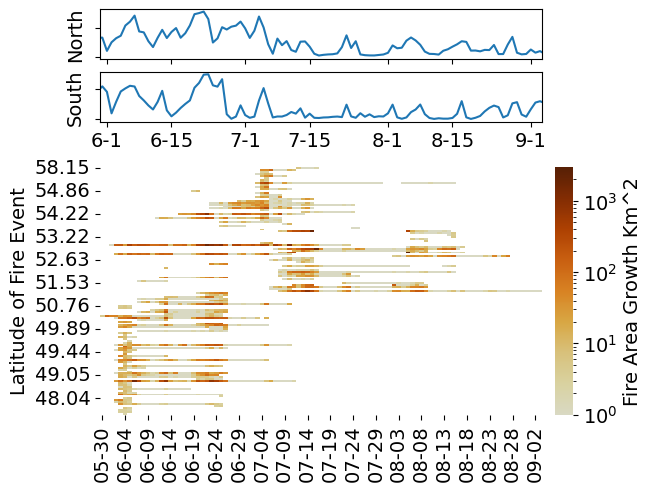

In [167]:
with mpl.rc_context({'font.size': 14}):
    fig1, ([ax, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, gridspec_kw={'width_ratios':[100,4], 'height_ratios': [1,1, 5]}, constrained_layout=True)
    #fig.suptitle('Aligning x-axis using sharex')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    ax.plot(fwin.INITDATE.astype("datetime64[ns]"),fwin.GEOS_5)
    ax.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax.set_ylabel("North")
    ax.set_xticklabels("")
    ax.set_yticklabels("")


    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%-d'))
    ax3.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
    ax3.set_xlim(test_func[1].t.astype("datetime64[ns]").min(), test_func[1].t.astype("datetime64[ns]").max())
    ax3.set_ylabel("South")
    ax3.set_yticklabels("")



    #ax3 = 
    #sn.heatmap(heat, cmap = "YlOrBr", norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    sn.heatmap(test_func[0], cmap = darker_cmap, norm=LogNorm(), cbar_kws={'label': 'Fire Area Growth Km^2'}, ax = ax5, cbar_ax=ax6, square=False)#,fmt='.1f', 
    ax5.set(xlabel="", ylabel="Latitude of Fire Event")
    #ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.remove()
    ax4.remove()
    
    plt.savefig('low_rez_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [107]:
fwis.INITDATE.astype("datetime64[ns]").min()

Timestamp('2023-01-01 00:00:00')

In [114]:
get_fwi = make_heat_map("/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Quebec_all_fires_merged_together_06172024.csv", "FWI")

/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = df_tmp[df_tmp.t == max_t].centroid.x
/tmp/ipykernel_6747/4035619963.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = df_tmp[df_tmp.t == max_t].centroid.y
/tmp/ipykernel_6747/4035619963.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS b

modifying values to fit log color scale: 0 -> 1, nagative number -> 1


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


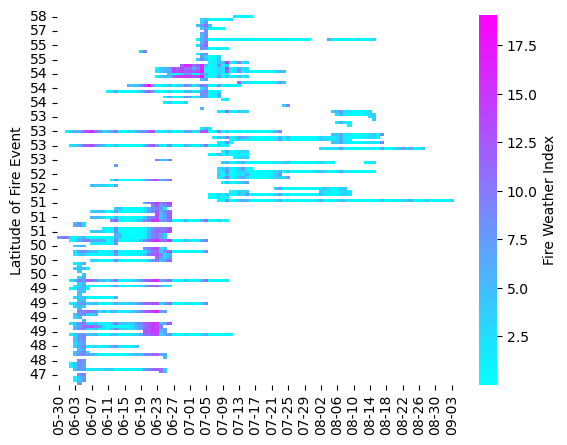

In [168]:
fig2, (ax2) = plt.subplots(1)
#fig.suptitle('Aligning x-axis using sharex')
ax2 = sn.heatmap(get_fwi[0], cmap = "cool", cbar_kws={'label': 'Fire Weather Index'}, fmt='.1f')#, 
               #yticklabels=heat.index.values.round(0))
ax2.set(xlabel="", ylabel="Latitude of Fire Event")
ax2.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(quick_round2))


#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax.plot(fwis.INITDATE.astype("datetime64[ns]"),fwis.GEOS_5)
#ax.set_xlim(get_fwi[1].t.astype("datetime64[ns]").min(), get_fwi[1].t.astype("datetime64[ns]").max())
#ax.set_ylabel("FWI")

#plt.savefig('FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = True)

plt.savefig('/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/FWI_for_darker_Regional_fire_growth_FWI.png', dpi = 900, transparent = False)

In [153]:
heat.index[120]

48.04

In [ ]:
# from matplotlib.image import imread

# fig1 = imread('FWI_for_darker_Regional_fire_growth_FWI.png')
# fig2 = imread('low_rez_darker_Regional_fire_growth_FWI.png')
# fig3 = imread('Quebec_largefire.png')  # Assuming fig3 is another figure

# # Plot them in a grid layout
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# axes[0].imshow(fig1)
# axes[1].imshow(fig2)
# axes[2].imshow(fig3)

# plt.tight_layout()
# plt.show()



# # from PIL import Image

# # # Load and resize images
# # fig1 = Image.open('FWI_for_darker_Regional_fire_growth_FWI.png').resize((300, 300))  # Resize to 400x300 pixels
# # fig2 = Image.open('darker_Regional_fire_growth_FWI.png').resize((300, 300))  # Resize to 400x300 pixels
# # fig3 = Image.open('Quebec_largefire.png').resize((300, 300))  # Assuming fig3 is another figure

# # # Plot them in a grid layout
# # fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# # axes[0].imshow(fig1)
# # axes[1].imshow(fig2)
# # axes[2].imshow(fig3)

# # plt.tight_layout()
# # plt.show()